In [1]:
import os
import json
import time
import torch
import matplotlib.pyplot as plt

from torch.nn import L1Loss
from monai.utils import set_determinism, first
from monai.networks.nets import ViTAutoEnc
from monai.losses import ContrastiveLoss
from monai.data import DataLoader, Dataset
from monai.config import print_config
from monai.transforms import (
    LoadImaged,
    Compose,
    CropForegroundd,
    CopyItemsd,
    SpatialPadd,
    EnsureChannelFirstd,
    Spacingd,
    OneOf,
    ScaleIntensityRanged,
    RandSpatialCropSamplesd,
    RandCoarseDropoutd,
    RandCoarseShuffled,
    ScaleIntensityd
)

print_config()


MONAI version: 1.4.dev2414
Numpy version: 1.26.4
Pytorch version: 2.2.2+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 5b248f6a0dd29cb9c2a9545f980a88de16a6b753
MONAI __file__: /home/<username>/virtenvs/SSLUnet/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.13.0
Pillow version: 10.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.2
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.14.3
pynrrd version: 1.0.0
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about insta

In [2]:
# Load NRRD file
import nrrd
nrrd_file_path = "./Data/FrenchSpeakerDataset/NRRD_Files_N4Bias/P1_2.nrrd"
data, header = nrrd.read(nrrd_file_path)

In [5]:
# Define Training Transforms
train_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        #Defines the image intensity
        ScaleIntensityd(keys=["image"], minv=-0.0, maxv=1.0),
        CropForegroundd(keys=["image"], source_key="image"),
        SpatialPadd(keys=["image"], spatial_size=(64, 64, 64)),
        RandSpatialCropSamplesd(keys=["image"], roi_size=(
            64, 64, 64), random_size=False, num_samples=2),
        CopyItemsd(keys=["image"], times=2, names=[
            "gt_image", "image_2"], allow_missing_keys=False),
        OneOf(
            transforms=[
                RandCoarseDropoutd(
                    keys=["image"], prob=1.0, holes=6, spatial_size=5, dropout_holes=True, max_spatial_size=32
                ),
                RandCoarseDropoutd(
                    keys=["image"], prob=1.0, holes=6, spatial_size=20, dropout_holes=False, max_spatial_size=64
                ),
            ]
        ),
        RandCoarseShuffled(keys=["image"], prob=0.8, holes=10, spatial_size=8),
        # Please note that that if image, image_2 are called via the same transform call because of the determinism
        # they will get augmented the exact same way which is not the required case here, hence two calls are made
        OneOf(
            transforms=[
                RandCoarseDropoutd(
                    keys=["image_2"], prob=1.0, holes=6, spatial_size=5, dropout_holes=True, max_spatial_size=32
                ),
                RandCoarseDropoutd(
                    keys=["image_2"], prob=1.0, holes=6, spatial_size=20, dropout_holes=False, max_spatial_size=64
                ),
            ]
        ),
        RandCoarseShuffled(keys=["image_2"], prob=0.8,
                           holes=10, spatial_size=8),
    ]
)

# Load NRRD file
nrrd_file_path = "Data/FrenchSpeakerDataset/NRRD_Files_N4Bias/P10_y.nrrd"
data, header = nrrd.read(nrrd_file_path)

# Create a dictionary with your image data
data_dict = {"image": nrrd_file_path}

# Apply the transformations
transformed_data_dict = train_transforms(data_dict)

# Visualize the original and transformed images
original_image = data_dict["image"]  # assuming the original image is 3D


In [6]:
transformed_data_dict[0]["gt_image"].shape
#plt.imshow(transformed_image["image"]["gt_image"][:,:,15])

torch.Size([1, 64, 64, 64])

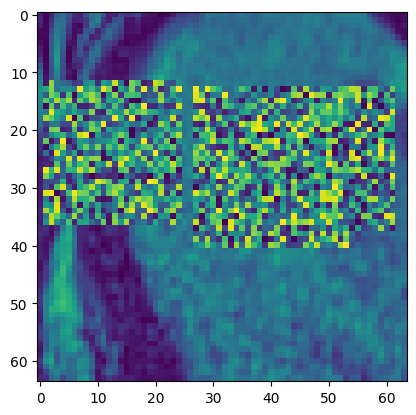

In [55]:
# Plot original and transformed images
import matplotlib.pyplot as plt
plt.imshow(transformed_image[0]["image_2"].numpy()[0, :, :, 40])


In [56]:
# Access the original and duplicated images
original_image = transformed_data_dict[0]["image"]
gt_image = transformed_data_dict[0]["gt_image"]
image_2 = transformed_data_dict[0]["image_2"]

# Print the keys and shapes of the images
print("Original Image Shape:", original_image.shape)
print("GT Image Shape:", gt_image.shape)
print("Image 2 Shape:", image_2.shape)


Original Image Shape: torch.Size([1, 64, 64, 64])
GT Image Shape: torch.Size([1, 64, 64, 64])
Image 2 Shape: torch.Size([1, 64, 64, 64])


(1, 5, 256, 256, 64) (1, 5, 256, 256, 64) 0.0


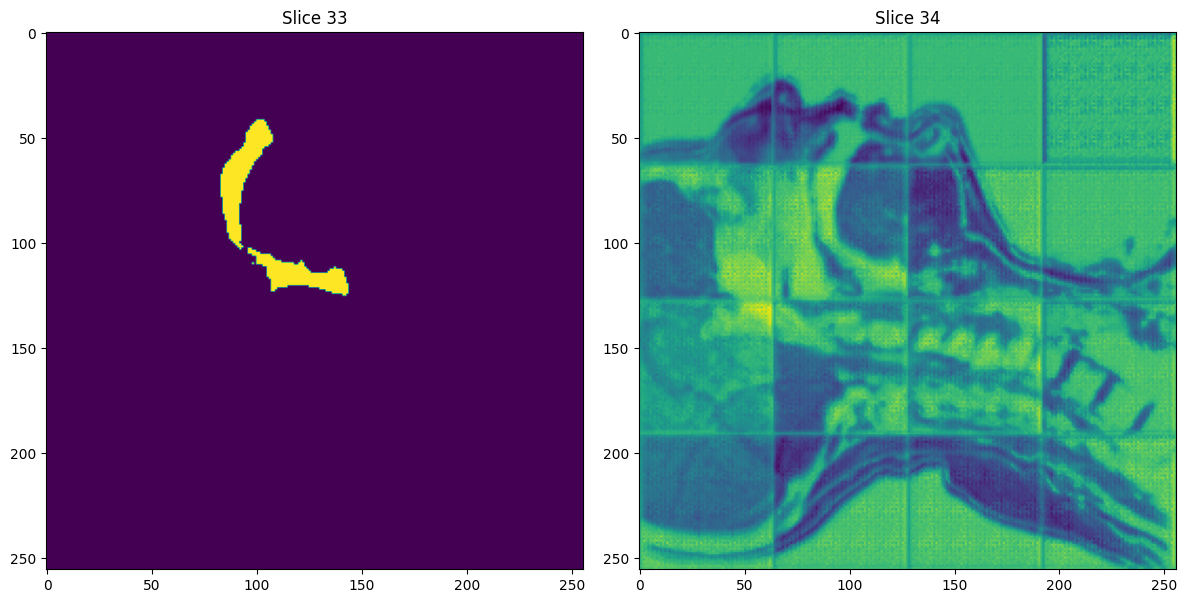

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Load the numpy file
data = np.load('../logs/FourD/FourD_0.017774497903883458_label.npy')
output = np.load('../logs/FourD/FourD_0.017774497903883458.npy')
slice_num = 34 
# Show slices of the data
print(data.shape,output.shape, np.min(data))

# Iterate over the last dimension and display each slice
# for i in range(data.shape[-1]):  # Assuming the last dimension has images
#     plt.figure()
#     plt.imshow(data[0, 0, :, :, i])
#     plt.colorbar(label='Data Values')
#     plt.title({i})  # Add a colorbar to show data values
# plt.show()
# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Display the first slice in the first subplot
axs[0].imshow(data[0, 4, :, :, slice_num])
axs[0].set_title('Slice 33')

# Display the second slice in the second subplot
axs[1].imshow(output[0,4, :, :, slice_num])
axs[1].set_title('Slice 34')

plt.tight_layout()  # Adjust the layout
plt.show()


In [11]:
np.min(output)

-0.36157158

In [21]:
import os
import nrrd

def check_nrrd_shapes(directory):
    shapes = []
    for filename in os.listdir(directory):
        if filename.endswith('.nrrd'):
            data, header = nrrd.read(os.path.join(directory, filename))
            print(filename,data.shape)
            shapes.append(data.shape)
    
    if len(set(shapes)) == 1:
        print("All nrrd files have the same shape:", shapes[0], len(shapes))
    else:
        print("Shapes are not the same. Found shapes:", shapes)

# Replace 'your_directory_path' with the path to your nrrd files
check_nrrd_shapes('../Data/VoiceUsers/Train/Train/')


14 3DGRE_o NO_2_2.nrrd (256, 256, 64)
13 3DGRE_A FATHER 3D_2 copy.seg.nrrd (256, 256, 64)
15 3DGRE_u FOOD.nrrd (256, 256, 64)
6 3DGRE_E HEAD.seg.nrrd (256, 256, 64)
7 3DGRE_o NO copy.nrrd (256, 256, 64)
5 3DGRE_I FEET 3D.nrrd (256, 256, 64)
7 3DGRE_o NO.seg.nrrd (256, 256, 64)
6 3DGRE_E HEAD.nrrd (256, 256, 64)
17 3DGRE_I FEET 3D_2_2.seg.nrrd (256, 256, 64)
14 3DGRE_E HEAD_2.seg.nrrd (256, 256, 64)
13 3DGRE_E HEAD.nrrd (256, 256, 64)
13 3DGRE_A FATHER 3D_2.nrrd (256, 256, 64)
7 3DGRE_o NO.nrrd (256, 256, 64)
12 3DGRE_A FATHER 3D_2_2.seg.nrrd (256, 256, 64)
15 3DGRE_u FOOD.seg.nrrd (256, 256, 64)
11 3DGRE_I FEET 3D_1.seg.nrrd (256, 256, 64)
5 3DGRE_I FEET 3D.seg.nrrd (256, 256, 64)
15 3DGRE_u FOOD_2_2.seg.nrrd (256, 256, 64)
10 3DGRE_I FEET 3D.nrrd (256, 256, 64)
13 3DGRE_E HEAD.seg.nrrd (256, 256, 64)
12 3DGRE_A FATHER 3D_2_2.nrrd (256, 256, 64)
6 3DGRE_E HEAD_7.seg.nrrd (256, 256, 64)
12 3DGRE_I FEET 3D.seg.nrrd (256, 256, 64)
7 3DGRE_o NO copy.seg.nrrd (256, 256, 64)
12 3DGRE_U HOOP 

In [22]:
### check the datagenerator
import os
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import argparse
from torch.nn import DataParallel

from monai.losses import DiceCELoss, DiceLoss
from monai.inferers import sliding_window_inference
from monai.config import print_config
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    Resized,
    ScaleIntensityd,
    SpatialPadd,
    RandSpatialCropSamplesd,
    LambdaD,
    ConcatItemsd,
    NormalizeIntensityd
)
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR
from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

train_dir="../Data/VoiceUsers/Train/Train/"
val_dir="../Data/VoiceUsers/Val/Nasal25/"

# %%
# Convert train and validation images into lists with locations
train_nrrd_files = sorted([os.path.join(train_dir, f) for f in os.listdir(
    train_dir) if f.endswith(".nrrd") and not f.endswith(".seg.nrrd")])
train_seg_nrrd_files = sorted([os.path.join(train_dir, f)
                              for f in os.listdir(train_dir) if f.endswith(".seg.nrrd")])

val_nrrd_files = sorted([os.path.join(val_dir, f) for f in os.listdir(
    val_dir) if f.endswith(".nrrd") and not f.endswith(".seg.nrrd")])
val_seg_nrrd_files = sorted([os.path.join(val_dir, f)
                            for f in os.listdir(val_dir) if f.endswith(".seg.nrrd")])

train_datalist = [{"image": img, "label": lbl}
                  for img, lbl in zip(train_nrrd_files, train_seg_nrrd_files)]
validation_datalist = [{"image": img, "label": lbl}
                       for img, lbl in zip(val_nrrd_files, val_seg_nrrd_files)]
print(f" Trian datalist setup {train_datalist[0]}")

# %%
# Define transforms for training and validation
def binarize_label(label):
    return (label > 0).astype(label.dtype)

def threshold_image(image):
    print(image.shape)
    #return np.where(image < 0.08, 0, image)

def print_shape(key):
    return LambdaD(keys=key, func=lambda x: print(f"Shape of {key}: {x.shape}") or x)

train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    print_shape("image"),
    print_shape("label"),
    EnsureChannelFirstd(keys=["image", "label"]),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    ScaleIntensityd(keys=["image"], minv=0, maxv=1),
    LambdaD(keys="label", func=binarize_label),
    #LambdaD(keys="image", func=threshold_image),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    SpatialPadd(keys=["image", "label"], spatial_size=(64, 128, 128,)),
    RandSpatialCropSamplesd(keys=["image", "label"], roi_size=(
        64, 128, 128), random_size=False, num_samples=2),
    RandFlipd(keys=["image", "label"], spatial_axis=[0], prob=0.10),
    RandFlipd(keys=["image", "label"], spatial_axis=[1], prob=0.10),
    RandFlipd(keys=["image", "label"], spatial_axis=[2], prob=0.10),
    RandRotate90d(keys=["image", "label"], prob=0.05, max_k=3),
    RandShiftIntensityd(keys=["image"], offsets=0.10, prob=0.05),
    ToTensord(keys=["image", "label"]),
])

# Validation transforms
val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    ScaleIntensityd(keys=["image"], minv=0, maxv=1),
    LambdaD(keys="label", func=binarize_label),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    SpatialPadd(keys=["image", "label"], spatial_size=(64, 128, 128)),
    RandSpatialCropSamplesd(keys=["image", "label"], roi_size=(
        64, 128, 128), random_size=False, num_samples=2),
    print_shape("image"),
    print_shape("label"),
    ToTensord(keys=["image", "label"]),
])

# %%
    
# Create DataLoaders for training and validation
train_ds = CacheDataset(data=train_datalist, transform=train_transforms,
                        cache_num=24, cache_rate=1.0, num_workers=2)
train_loader = DataLoader(train_ds, batch_size=1,
                          shuffle=True, num_workers=4, pin_memory=True )

val_ds = CacheDataset(data=validation_datalist, transform=val_transforms,
                      cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1,
                        shuffle=False, num_workers=4, pin_memory=True)


/home/erattakulangara/.conda/envs/unetSSL/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


 Trian datalist setup {'image': '../Data/VoiceUsers/Train/Train/10 3DGRE_I FEET 3D.nrrd', 'label': '../Data/VoiceUsers/Train/Train/10 3DGRE_I FEET 3D.seg.nrrd'}


Loading dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])
Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])


Loading dataset:   4%|▍         | 1/24 [00:00<00:11,  2.04it/s]

Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])
Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])


Loading dataset:  17%|█▋        | 4/24 [00:00<00:04,  4.65it/s]

Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])
Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])


Loading dataset:  25%|██▌       | 6/24 [00:01<00:03,  4.83it/s]

Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])


Loading dataset:  29%|██▉       | 7/24 [00:01<00:02,  5.67it/s]

Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])
Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])


Loading dataset:  38%|███▊      | 9/24 [00:01<00:02,  5.92it/s]

Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])
Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])


Loading dataset:  46%|████▌     | 11/24 [00:02<00:02,  6.20it/s]

Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])
Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])


Loading dataset:  50%|█████     | 12/24 [00:02<00:02,  5.44it/s]

Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])
Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])


Loading dataset:  58%|█████▊    | 14/24 [00:02<00:01,  5.61it/s]

Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])
Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])


Loading dataset:  67%|██████▋   | 16/24 [00:03<00:01,  5.67it/s]

Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])
Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])


Loading dataset:  75%|███████▌  | 18/24 [00:03<00:01,  5.85it/s]

Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])
Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])


Loading dataset:  83%|████████▎ | 20/24 [00:03<00:00,  5.97it/s]

Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])
Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])


Loading dataset:  92%|█████████▏| 22/24 [00:04<00:00,  5.99it/s]

Shape of image: torch.Size([256, 256, 64])
Shape of label: torch.Size([256, 256, 64])


Loading dataset: 100%|██████████| 5/5 [00:00<00:00,  6.18it/s]


In [23]:
# Test run the training DataLoader
print("Sample from Training DataLoader:")
for i, data in enumerate(train_loader):
    # Assuming data is a tuple (input, target)
    inputs, targets = data["image"], data["label"]  # Modify according to your data structure
    print(f"Batch {i + 1}:")
    print("Inputs shape:", inputs.shape)  # Print input shape
    print("Targets shape:", targets.shape)  # Print target shape
    # Optionally break after first batch to avoid lengthy output
    break
    if i == 0:
        break



Sample from Training DataLoader:


> collate dict key "image" out of 4 keys
>> collate/stack a list of tensors
>> E: stack expects each tensor to be equal size, but got [1, 128, 64, 128] at entry 0 and [1, 64, 128, 128] at entry 1, shape [torch.Size([1, 128, 64, 128]), torch.Size([1, 64, 128, 128])] in collate([metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.

Batch 1:
Inputs shape: torch.Size([2, 1, 64, 128, 128])
Targets shape: torch.Size([2, 1, 64, 128, 128])
